In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
def extract_keypoints(frame, fast, orb, use_ssc=False,
    ssc_num_retain_points=3000, ssc_threshold=0.1):
    """Extracts FAST feature points and ORB descriptors in the frame."""
    kp = fast.detect(frame, None)
    kp = sorted(kp, key = lambda x:x.response, reverse=True)
    kp, des = orb.compute(frame, kp)
    return kp, des


def match(bf, last_keyframe, frame, last_des, des, last_kp, kp, distance_threshold=30.0, draw=True):
    matches = bf.match(last_des, des)
    matches = sorted(matches, key = lambda x:x.distance)
    # filter out matches with distance (descriptor appearance) greater than threshold
    matches = [m for m in matches if m.distance < distance_threshold]
    print("Found {} matches of current frame with last key frame".format(len(matches)))
    last_pts = np.array([last_kp[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
    current_pts = np.array([kp[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)
    match_frame = np.zeros_like(frame)
    if draw:
        match_frame = cv2.drawMatches(last_keyframe, last_kp, frame, kp, matches, None)
    return matches, last_pts, current_pts, match_frame


def to_celsius(image):
    """Convert raw intensity values of radiometric image to Celsius scale."""
    return image*0.04-273.15


def preprocess_radiometric_frame(frame, equalize_hist=True):
    """Preprocesses raw radiometric frame.

    First, the raw 16-bit radiometric intensity values are converted to Celsius
    scale. Then, the image values are normalized to range [0, 255] and converted
    to 8-bit. Finally, histogram equalization is performed to normalize
    brightness and enhance contrast.
    """
    frame = to_celsius(frame)
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = (frame*255.0).astype(np.uint8)
    if equalize_hist:
        frame = cv2.equalizeHist(frame)
        # CLAHE results in vastly different numbers of feature points depending on clipLimit 
        #clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
        #frame = clahe.apply(frame)
    return frame

In [4]:
img = cv2.imread("frame_000030.tiff", cv2.IMREAD_ANYDEPTH)
img = preprocess_radiometric_frame(img)

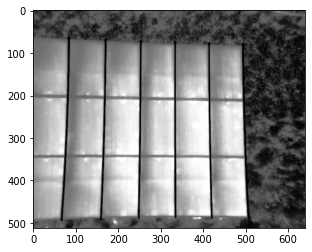

In [5]:
plt.imshow(img, cmap="gray")
plt.show()

In [6]:
orb = cv2.ORB_create()
fast = cv2.FastFeatureDetector_create(threshold=12, nonmaxSuppression=True)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

kp, des = extract_keypoints(img, fast, orb)

In [7]:
pts = [p.octave for p in kp]

In [8]:
[cv2.KeyPoint(p) for p in pts]

TypeError: Required argument 'y' (pos 2) not found

In [9]:
octaves = [p.octave for p in kp]

In [10]:
points2f = cv2.KeyPoint_convert(kp)

In [11]:
points2f

array([[331., 338.],
       [331., 214.],
       [413., 348.],
       ...,
       [437., 479.],
       [569., 479.],
       [589., 480.]], dtype=float32)

In [12]:
kp_ = cv2.KeyPoint_convert(points2f.reshape(-1, 1, 2))

In [18]:
kp[0] == kp_[0]

False

In [ ]:


pt	x & y coordinates of the keypoint
_size	keypoint diameter
_angle	keypoint orientation
_response	keypoint detector response on the keypoint (that is, strength of the keypoint)
_octave	pyramid octave in which the keypoint has been detected
_class_id	o

In [24]:
print(kp[0].pt,
kp[0].size,
kp[0].angle,
kp[0].response,
kp[0].octave,
kp[0].class_id)

print(kp_[0].pt,
kp_[0].size,
kp_[0].angle,
kp_[0].response,
kp_[0].octave,
kp_[0].class_id)

(331.0, 338.0) 7.0 -1.0 111.0 0 -1
(331.0, 338.0) 1.0 -1.0 1.0 0 -1
